In [47]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import gym
import random
from gym import spaces
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, SpatialDropout1D,SimpleRNN,Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import  Dropout, MultiHeadAttention,Input,LayerNormalization,GlobalAveragePooling1D
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
print(tf.__version__)

2.16.1


In [3]:
dataset = pd.read_csv('dataset/mbti_1.csv')

In [4]:
dataset.head(10)

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...
5,INTJ,'18/37 @.@|||Science is not perfect. No scien...
6,INFJ,"'No, I can't draw on my own nails (haha). Thos..."
7,INTJ,'I tend to build up a collection of things on ...
8,INFJ,"I'm not sure, that's a good question. The dist..."
9,INTP,'https://www.youtube.com/watch?v=w8-egj0y8Qs||...


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


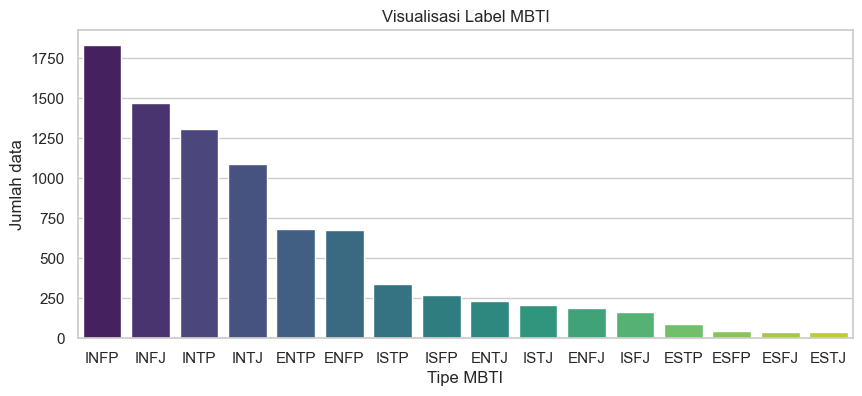

In [6]:
# visualisasi labels mbti
sns.set(style="whitegrid")
plt.figure(figsize=(10,4))
mbti_counts = dataset['type'].value_counts()
sns.barplot(x=mbti_counts.index, y=mbti_counts.values, hue=mbti_counts.index, palette='viridis', legend=False)
plt.title('Visualisasi Label MBTI')
plt.xlabel('Tipe MBTI')
plt.ylabel('Jumlah data')
plt.show()

In [7]:
# Fungsi Menghapus URL menggunakan regular expression
def hapus_url(text):
    return re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)

# Fungsi Menghapus karakter non-alfabetik menggunakan regular expression
def hapus_nonalfabet(text):
    return re.sub(r'[^a-zA-Z\s]', '', text)

# Fungsi Mengonversi teks menjadi huruf kecil
def konversi_huruf_kecil(text):
    return text.lower()

# Fungsi Menghapus spasi 
def hapus_spasi(text):
    return ' '.join(text.split())

In [8]:
dataset_url = [hapus_url(post) for post in dataset['posts']]
dataset_nonalfabet = [hapus_nonalfabet(post) for post in dataset_url]
dataset_huruf_kecil = [konversi_huruf_kecil(post) for post in dataset_nonalfabet]
pembersihan_data = [hapus_spasi(post) for post in dataset_huruf_kecil]

In [9]:
# Menyimpan data setelah pembersihan
dataset['posts'] = pembersihan_data

In [10]:
dataset.head(10)

,type,posts
0,INFJ,enfp and intj moments sportscenter not top ten...
1,ENTP,im finding the lack of me in these posts very ...
2,INTP,good one of course to which i say i know thats...
3,INTJ,dear intp i enjoyed our conversation the other...
4,ENTJ,youre firedthats another silly misconception t...
5,INTJ,science is not perfect no scientist claims tha...
6,INFJ,no i cant draw on my own nails haha those were...
7,INTJ,i tend to build up a collection of things on m...
8,INFJ,im not sure thats a good question the distinct...
9,INTP,im in this position where i have to actually l...


In [11]:
# Analisis Frekuensi kata
analisis_kata = CountVectorizer(stop_words='english')
X = analisis_kata.fit_transform(dataset['posts'])
kata_frekuensi = dict(zip(analisis_kata.get_feature_names_out(), X.sum(axis=0).A1))
kata_frekuensi_df = pd.DataFrame(list(kata_frekuensi.items()), columns=['kata', 'frekuensi']).sort_values(by='frekuensi', ascending=False)
kata_frekuensi_df.head(10)

,kata,frekuensi
153704,like,67149
126200,im,65769
144219,just,52641
69708,dont,50999
269178,think,48648
199605,people,44118
147265,know,35686
218183,really,34032
273026,time,25534
141233,ive,24124


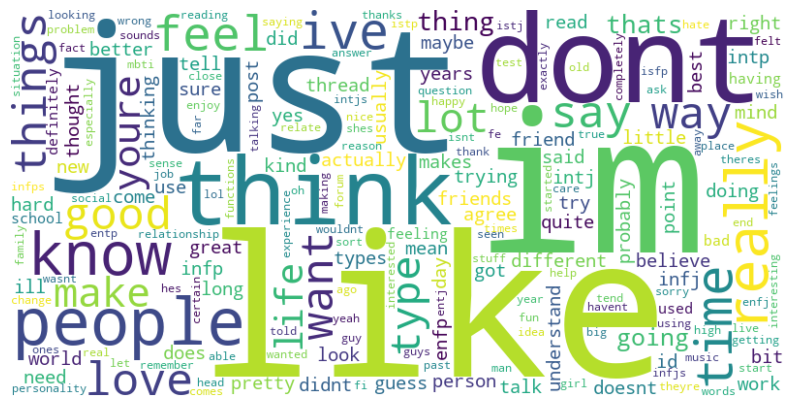

In [12]:
# Visualisasi Frekuensi kata
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(kata_frekuensi)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

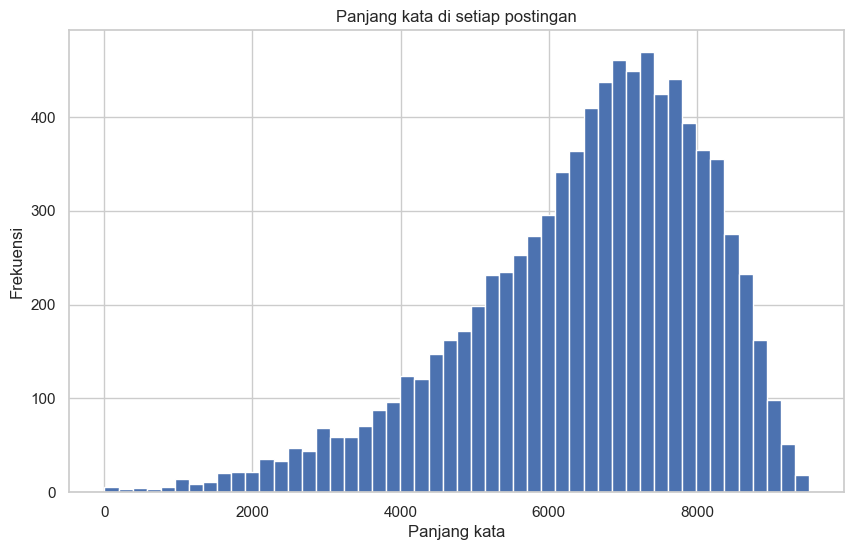

In [13]:
# Analisis panjangan kata
dataset['panjang_kata'] = dataset['posts'].apply(len)
plt.figure(figsize=(10, 6))
dataset['panjang_kata'].hist(bins=50)
plt.title('Panjang kata di setiap postingan')
plt.xlabel('Panjang kata')
plt.ylabel('Frekuensi')
plt.show()


In [14]:
dataset

,type,posts,panjang_kata
0,INFJ,enfp and intj moments sportscenter not top ten...,3079
1,ENTP,im finding the lack of me in these posts very ...,5957
2,INTP,good one of course to which i say i know thats...,4548
3,INTJ,dear intp i enjoyed our conversation the other...,5667
4,ENTJ,youre firedthats another silly misconception t...,5322
...,...,...,...
8670,ISFP,ixfp just because i always think of cats as fi...,4375
8671,ENFP,soif this thread already exists someplace else...,6992
8672,INTP,so many questions when i do these things i wou...,5137
8673,INFP,i am very conflicted right now when it comes t...,8783


In [52]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(dataset['posts'])
sequences = tokenizer.texts_to_sequences(dataset['posts'])
X_data = pad_sequences(sequences, maxlen=500)

In [54]:
X_data

array([[   0,    0,    0, ...,  109,   14,  102],
       [  41,   39,  576, ...,    1,   15,    9],
       [  81,  175,  126, ...,    2,   20,  339],
       ...,
       [  90, 1222,   14, ...,   41,  257,  164],
       [  58,    2,   33, ...,   15, 1259,  190],
       [ 181,  176,    1, ...,   64,   14,   17]])

In [53]:
labels = dataset['type'].astype('category').cat.codes
y_data = labels.values

In [57]:
y_data

array([ 8,  3, 11, ..., 11,  9,  9], dtype=int8)

In [37]:
class MBTIEnvironment(gym.Env):
    def __init__(self):
        super(MBTIEnvironment, self).__init__()
        self.action_space = spaces.Discrete(4)  # Misalnya, empat tindakan arbitrer
        self.observation_space = spaces.Discrete(16)  # Misalnya, 16 tipe kepribadian MBTI

    def step(self, action):
        # Implementasi perubahan state dan perhitungan reward
        state = np.random.choice(range(16))
        reward = np.random.rand()
        done = np.random.choice([True, False], p=[0.1, 0.9])
        info = {}
        return state, reward, done, info

    def reset(self):
        # Reset state ke keadaan awal
        return np.random.choice(range(16))

    def render(self, mode='human'):
        pass

    def close(self):
        pass

In [38]:
def initialize_q_table(n_states, n_actions):
    return np.zeros((n_states, n_actions))

n_states = 16  
n_actions = 4  
q_table = initialize_q_table(n_states, n_actions)

In [39]:
def train_q_learning(env, q_table, episodes, alpha, gamma, epsilon):
    for episode in range(episodes):
        state = env.reset()
        done = False

        while not done:
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()  # Eksplorasi
            else:
                action = np.argmax(q_table[state])  # Eksploitasi

            next_state, reward, done, info = env.step(action)
            old_value = q_table[state, action]
            next_max = np.max(q_table[next_state])

            # Update Q-table
            q_table[state, action] = old_value + alpha * (reward + gamma * next_max - old_value)
            state = next_state

    return q_table

# Parameter pembelajaran
alpha = 0.1  # Learning rate
gamma = 0.6  # Discount factor
epsilon = 0.1  # Tingkat eksplorasi
episodes = 1000

# Membuat environment
env = MBTIEnvironment()

# Training model Q-learning
q_table = train_q_learning(env, q_table, episodes, alpha, gamma, epsilon)

In [40]:
def evaluate_policy(env, q_table, episodes):
    total_rewards = 0
    for _ in range(episodes):
        state = env.reset()
        done = False
        while not done:
            action = np.argmax(q_table[state])  # Selalu gunakan tindakan terbaik
            state, reward, done, info = env.step(action)
            total_rewards += reward
    average_reward = total_rewards / episodes
    return average_reward

# Evaluasi model
average_reward = evaluate_policy(env, q_table, 100)
print("Rata-rata Reward:", average_reward)

Rata-rata Reward: 5.208751748119251


In [41]:
def plot_q_table(q_table):
    plt.figure(figsize=(12, 8))
    sns.heatmap(q_table, annot=True, cmap="coolwarm")
    plt.title('Heatmap of Q-Table')
    plt.xlabel('Actions')
    plt.ylabel('States')
    plt.show()

In [42]:
def plot_rewards(rewards, window_size=100):
    # Menghitung moving average dari rewards
    moving_avg_rewards = [np.mean(rewards[i:i+window_size]) for i in range(len(rewards) - window_size)]
    plt.figure(figsize=(12, 8))
    plt.plot(moving_avg_rewards)
    plt.title('Reward Per Episode (Moving Average)')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.show()

In [46]:
# Mengasumsikan kita telah mengumpulkan rewards selama training untuk plot
rewards = [np.random.rand() + (i * 0.01) for i in range(1000)]

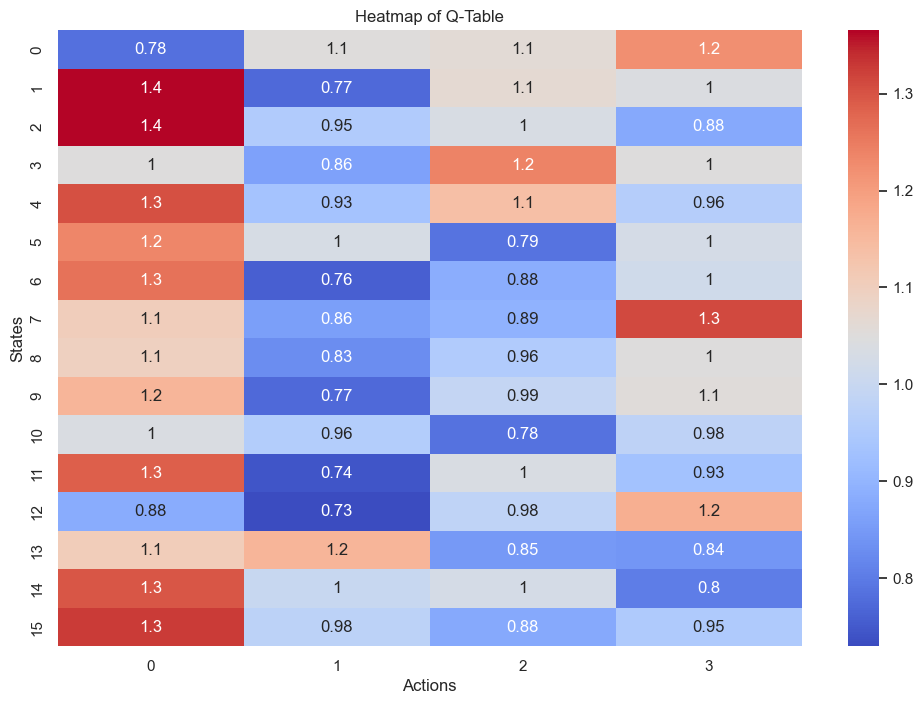

In [44]:
# Menampilkan Q-Table
plot_q_table(q_table)

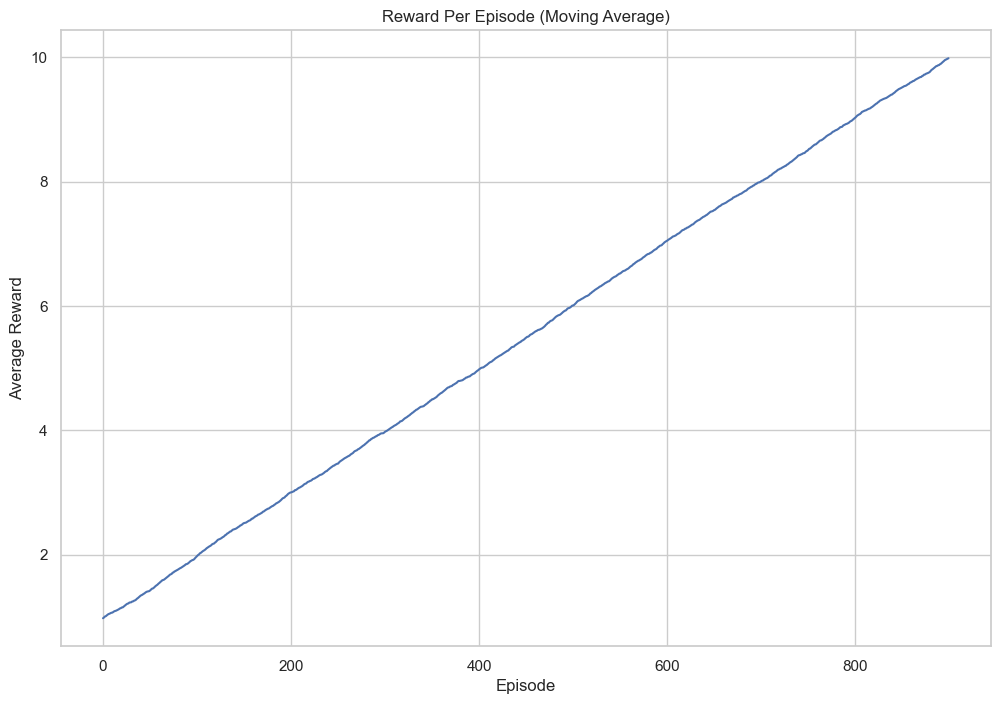

In [45]:
# Menampilkan rewards
plot_rewards(rewards)